# Technical Meeting on the Deployment of Artificial Intelligence Solutions for the Nuclear Power Industry: Considerations and Guidance
# 18-21 March 2024, Rockville, United States of America
## APPLICATIONS OF AI IN THE QUALITY CONTROL OF SMR FUEL PELLETS

In this notebook you can test the application of some pre-trained networks on the problem of semantic segmentation over nuclear fuel pellets. It uses the API developed by Pavel Iakubovskii, you can check on his [github repository](https://github.com/qubvel/segmentation_models).

In [1]:
import tensorflow as tf

image_directory = './Data/final_dataset/images'
masks_directory = './Data/final_dataset/masks'

# Setting GPU memory growth to True
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [2]:
import os
from tensorflow import keras
from keras import backend as K 
from segmentation_models import get_preprocessing
import functions as func
import segmentation_models as sm

os.environ["SM_FRAMEWORK"] = "tf.keras"

X_train, y_train, X_val, y_val, X_test, y_test = func.augmented_dataset(image_directory, masks_directory, seed=42, norm=False)

#Each backbone needs different preprocessed data
preprocess_input_resnet152 = get_preprocessing('resnet152')
preprocess_input_vgg19 = get_preprocessing('vgg19')
preprocess_input_efficientnetb2 = get_preprocessing('efficientnetb2')

# binary segmentation 
model_resnet_152 = sm.Unet('resnet152', classes=1, activation='sigmoid', encoder_weights='imagenet')
model_vgg19 = sm.Unet('vgg19', classes=1, activation='sigmoid', encoder_weights='imagenet')
model_efficientnetb2 = sm.Unet('efficientnetb2', classes=1, activation='sigmoid', encoder_weights='imagenet')

'''
Models:

We will test with three models (Resnet152, VGG-19 and EfficientNet (b2 model))
The metrics and the training hyperparameters will be the same, feel free to explore

'''
model_resnet_152.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score, sm.metrics.FScore()],       
)

model_vgg19.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score, sm.metrics.FScore()],       
)

model_efficientnetb2.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score, sm.metrics.FScore()],       
)

#Let's define some common hyperparameters and callbacks for early stopping
batch_size=16
epochs=50
patience=20
early_stopping_cb=keras.callbacks.EarlyStopping(patience=patience,monitor='val_loss', restore_best_weights=True)

Segmentation Models: using `keras` framework.


## ResNet-152  
First, we try with a trained ResNet backbone.  
[Paper Link](https://arxiv.org/abs/1512.03385)

In [3]:
X_train_resnet = preprocess_input_resnet152(X_train)
X_val_resnet = preprocess_input_resnet152(X_val)

history_resnet = model_resnet_152.fit(
    x=X_train_resnet,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_resnet, y_val),
    callbacks=[early_stopping_cb]
)

# If you want to save the trained model
#print("Saving Model...")
#model_resnet_152.save('model_resnet_152.keras') 


Epoch 1/50
36/36 [==============================] - 26s 246ms/step - loss: 1.1030 - iou_score: 0.1228 - f1-score: 0.2119 - val_loss: 2.1383 - val_iou_score: 2.4306e-09 - val_f1-score: 2.9280e-09
Epoch 2/50
36/36 [==============================] - 5s 143ms/step - loss: 0.6323 - iou_score: 0.4161 - f1-score: 0.5813 - val_loss: 1.1167 - val_iou_score: 0.0989 - val_f1-score: 0.1789
Epoch 3/50
36/36 [==============================] - 5s 145ms/step - loss: 0.4233 - iou_score: 0.6102 - f1-score: 0.7568 - val_loss: 0.6950 - val_iou_score: 0.3597 - val_f1-score: 0.5286
Epoch 4/50
36/36 [==============================] - 5s 144ms/step - loss: 0.3573 - iou_score: 0.6735 - f1-score: 0.8045 - val_loss: 0.5423 - val_iou_score: 0.5040 - val_f1-score: 0.6697
Epoch 5/50
36/36 [==============================] - 5s 145ms/step - loss: 0.3421 - iou_score: 0.6902 - f1-score: 0.8159 - val_loss: 0.4937 - val_iou_score: 0.5461 - val_f1-score: 0.7057
Epoch 6/50
36/36 [==============================] - 5s 136ms/

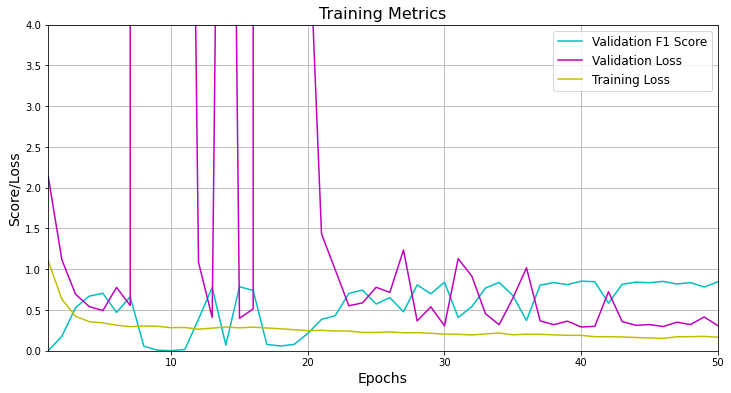

In [7]:
#let's plot some metrics, if you want to try others you can uncomment in the functions.py file
x_lim=50
y_lim=4
func.plot_history(history_resnet,x_lim, y_lim)

In [8]:
'''
ATTENTION
In "real life" it should not be used the test set for the model selection. 
is just to compare in this toy example
'''
X_test_resnet = preprocess_input_resnet152(X_test)

print("Resnet 152")
print("Validation results...")
model_resnet_152.evaluate(X_val_resnet, y_val)  
print("Test results...")
model_resnet_152.evaluate(X_test_resnet, y_test) 

#Saving the predictions on test, if you want inspect it later
pred_resnet_152 = model_resnet_152.predict(X_test_resnet)

Resnet 152
Validation results...
5/5 [==============================] - 3s 46ms/step - loss: 0.3100 - iou_score: 0.7370 - f1-score: 0.8482
Test results...
3/3 [==============================] - 2s 41ms/step


## VGG-19
[Paper Link](https://arxiv.org/abs/1409.1556v6)

In [9]:
X_train_vgg = preprocess_input_vgg19(X_train)
X_val_vgg = preprocess_input_vgg19(X_val)

history_vgg = model_vgg19.fit(
    x=X_train_vgg,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_vgg, y_val),
    callbacks=[early_stopping_cb]
)

#print("Saving Model...")
#model_vgg19.save('model_vgg19.keras') 


Epoch 1/50
36/36 [==============================] - 8s 123ms/step - loss: 1.1581 - iou_score: 0.1103 - f1-score: 0.1949 - val_loss: 1.1568 - val_iou_score: 0.1356 - val_f1-score: 0.2385
Epoch 2/50
36/36 [==============================] - 3s 70ms/step - loss: 0.7246 - iou_score: 0.3371 - f1-score: 0.4985 - val_loss: 0.8769 - val_iou_score: 0.2366 - val_f1-score: 0.3823
Epoch 3/50
36/36 [==============================] - 3s 70ms/step - loss: 0.4569 - iou_score: 0.5761 - f1-score: 0.7296 - val_loss: 0.5826 - val_iou_score: 0.4614 - val_f1-score: 0.6308
Epoch 4/50
36/36 [==============================] - 2s 69ms/step - loss: 0.3690 - iou_score: 0.6612 - f1-score: 0.7955 - val_loss: 0.4290 - val_iou_score: 0.6018 - val_f1-score: 0.7510
Epoch 5/50
36/36 [==============================] - 3s 71ms/step - loss: 0.3414 - iou_score: 0.6895 - f1-score: 0.8156 - val_loss: 0.3928 - val_iou_score: 0.6446 - val_f1-score: 0.7835
Epoch 6/50
36/36 [==============================] - 3s 70ms/step - loss: 0

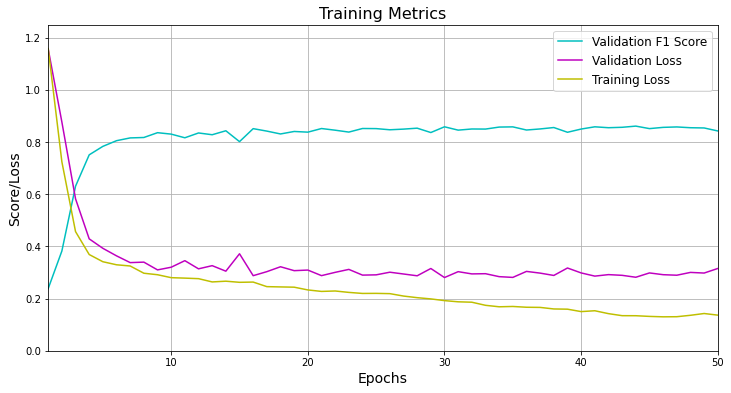

In [11]:
x_lim=50
y_lim=1.25
func.plot_history(history_vgg,x_lim, y_lim)

In [12]:
'''
ATTENTION
In "real life" it should not be used the test set for the model selection. 
is just to compare in this toy example
'''
X_test_vgg = preprocess_input_vgg19(X_test)
print("VGG 19")
print("Validation results...")
model_vgg19.evaluate(X_val_vgg, y_val)
print("Test results...")
model_vgg19.evaluate(X_test_vgg, y_test) 

#Saving the predictions on test, if you want inspect it later
pred_vgg19 = model_vgg19.predict(X_test_vgg)


VGG 19
Validation results...
5/5 [==============================] - 1s 28ms/step - loss: 0.2812 - iou_score: 0.7532 - f1-score: 0.8591
Test results...
3/3 [==============================] - 0s 30ms/step


## EfficientNet (b2 model)
[Paper Link](https://arxiv.org/abs/1905.11946)

In [13]:
X_train_eficient = preprocess_input_efficientnetb2(X_train)
X_val_eficient = preprocess_input_efficientnetb2(X_val)

history_efficient = model_efficientnetb2.fit(
    x=X_train_eficient,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_eficient, y_val),
    callbacks=[early_stopping_cb]
)

#print("Saving Model...")
#model_efficientnetb2.save('model_efficientnetb2.keras') 


Epoch 1/50
36/36 [==============================] - 17s 157ms/step - loss: 1.1193 - iou_score: 0.1279 - f1-score: 0.2222 - val_loss: 12.4433 - val_iou_score: 0.0276 - val_f1-score: 0.0537
Epoch 2/50
36/36 [==============================] - 3s 92ms/step - loss: 0.6831 - iou_score: 0.3711 - f1-score: 0.5336 - val_loss: 1.5064 - val_iou_score: 0.0630 - val_f1-score: 0.1185
Epoch 3/50
36/36 [==============================] - 3s 86ms/step - loss: 0.4108 - iou_score: 0.6181 - f1-score: 0.7620 - val_loss: 4.7149 - val_iou_score: 0.0486 - val_f1-score: 0.0926
Epoch 4/50
36/36 [==============================] - 3s 89ms/step - loss: 0.3410 - iou_score: 0.6867 - f1-score: 0.8135 - val_loss: 147.7823 - val_iou_score: 0.0187 - val_f1-score: 0.0368
Epoch 5/50
36/36 [==============================] - 3s 93ms/step - loss: 0.3004 - iou_score: 0.7256 - f1-score: 0.8406 - val_loss: 0.6541 - val_iou_score: 0.4164 - val_f1-score: 0.5849
Epoch 6/50
36/36 [==============================] - 3s 90ms/step - los

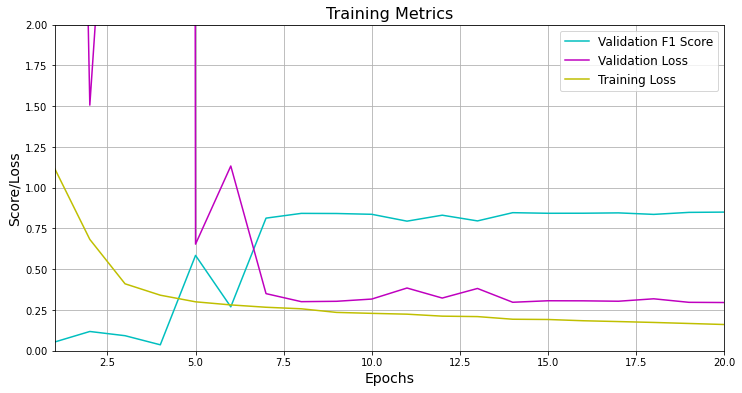

In [16]:
x_lim=20
y_lim=2
func.plot_history(history_efficient,x_lim, y_lim)

In [17]:
'''
ATTENTION
In "real life" it should not be used the test set for the model selection. 
is just to compare in this toy example
'''

X_test_eficient = preprocess_input_efficientnetb2(X_test)

print("Efficientnetb2")
print("Validation results...")
model_efficientnetb2.evaluate(X_val_eficient, y_val)

print("Test results...")
model_efficientnetb2.evaluate(X_test_eficient, y_test)  

#Saving the predictions on test, if you want inspect it later
pred_efficientnetb2 = model_efficientnetb2.predict(X_test_eficient)

Efficientnetb2
Validation results...
5/5 [==============================] - 2s 28ms/step - loss: 0.2970 - iou_score: 0.7422 - f1-score: 0.8519
Test results...
3/3 [==============================] - 2s 21ms/step
